In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# 실행 브라우저 시각화
%matplotlib inline

In [2]:
df = pd.read_pickle('LSWMD.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
folder_path = './wm_images'
file_list = os.listdir(folder_path)
for file_name in file_list:
    print(file_name)

test
train
val


In [4]:
df['failureNum']=df.failureType      # failureType을 failureNum 변수에 입력 
df['trainTestNum']=df.trianTestLabel # trianTestLabel을 trainTestNum 변수에 입력 (trainTestNum 데이터 자체 오타)

mapping_type={
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8}

mapping_traintest={'Training':0,'Test':1}

df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest}) #문자를 숫자로 치환

df_label = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_label = df_label.reset_index()
df_pattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_pattern = df_pattern.reset_index()
df_none = df[(df['failureNum']==8)]

# 1) 불량 총 갯수, 2) 불량 패턴, 3) none
df_label.shape[0], df_pattern.shape[0], df_none.shape[0]

(172950, 25519, 147431)

In [5]:
from PIL import Image

def save_image(image_data, save_dir, image_name):
    # 객체 생성
    width, height = len(image_data[0]), len(image_data)
    img = Image.new('RGB', (width, height))

    # 픽셀 색상 지정
    for y in range(height):
        for x in range(width):
            if image_data[y][x] == 0:
                img.putpixel((x,y), (255,255,255)) # 흰색
            elif image_data[y][x] == 1:
                img.putpixel((x,y), (255,200,0)) # 노랑
            elif image_data[y][x] == 2:
                img.putpixel((x,y), (0,50,200)) # 파랑

    # 저장 디렉토리
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 이미지 저장
    save_path = os.path.join(save_dir, image_name)
    img.save(save_path)

In [6]:
x = [0,1,2,3,4,5,6,7]

labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

# 불량 패턴별 총 갯수
for j in x:
    print('{} : {}'.format(labels[j], df_pattern.failureType[df_pattern.failureType == labels[j]].shape[0]))

Center : 4294
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Random : 866
Scratch : 1193
Near-full : 149


In [7]:
# 불량 패턴 8가지 원본 이미지 추출
for j in x:
    img = df_pattern.waferMap[df_pattern.failureType==labels[j]]
    for i in range(img.shape[0] - 1):
        image_data = img[img.index[i]]
        save_dir = './wm_images/' + str(df_pattern.failureType[img.index[i]][0][0])
        save_image(image_data, save_dir, 'wm_' + str(i) + '.bmp')

# none 추출 (1만개만 추출하여 그대로 사용)
img = df_none.waferMap[df_none.failureType=='none']
for i in range(10000):
    image_data = img[img.index[i]]
    save_dir = './wm_images/none'
    save_image(image_data, save_dir, 'wm_' + str(i) + '.bmp')

In [8]:
import random
import torch
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import save_image
import torchvision.transforms.functional as TF

def augment_images(save_dir, max_num_images=10000, seed=42):
    # 데이터 증강 파라미터 설정 파이프라인 정의
    transform = transforms.Compose([
        transforms.RandomRotation(40, fill=1), # 40도 회전
        #transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.8, 1.25)),  # 크기 조정 및 크롭
        transforms.RandomHorizontalFlip(), # 좌우 반전
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.15), shear=0.1, scale=(0.9, 1.1), fill=1), # 이동, 전단, 스케일 변환
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5), # 색상 변환
    ])

    random.seed(seed)
    image_file_list = os.listdir(save_dir)
    random.shuffle(image_file_list)
    max_num_augmented_images = max_num_images - len(image_file_list)
    num_augmentations = max_num_augmented_images // len(image_file_list) + 1

    i = 0
    for file_name in image_file_list:
        image_path = os.path.join(save_dir, file_name)
        image = Image.open(image_path).convert("RGB") # BMP 파일을 열고 RGB로 변환
        image = TF.to_tensor(image) # PIL 이미지를 PyTorch 텐서로 변환
        image = transforms.Resize((224, 224))(image) # 크기 조정
        
        for j in range(num_augmentations):
            augmented_image = transform(image)
            save_path = os.path.join(save_dir, f'{file_name}d_{j}.bmp')
            save_image(augmented_image, save_path)
            i += 1
            if i >= max_num_images:
                return

In [9]:
# 각 클래스별 이미지 증량

labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for i in range(len(labels)):
    save_dir = "./wm_images/{}".format(labels[i])
    augment_images(save_dir)

In [10]:
# 훈련 데이터셋

import shutil

def dir_exists(save_dir):
    # 저장될 디렉토리 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

# 각 클래스별 저장 폴더들
original_dir = './wm_images/'

train_dir = './wm_images/train/'
val_dir = './wm_images/val/'
test_dir = './wm_images/test/'

# 각 이미지 개수 설정
train_num = 6000
val_num = 2500
test_num = 1500

subdirs = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for subdir in subdirs:
    subdir_path = os.path.join(original_dir, subdir)
    img_list = os.listdir(subdir_path)
    random.shuffle(img_list) # 이미지 파일 섞기

    total_imgs = len(img_list) # 실제 이미지 개수 확인
    train_end_idx = min(train_num, total_imgs)
    val_end_idx = min(train_end_idx + val_num, total_imgs)
    test_end_idx = min(val_end_idx + test_num, total_imgs)

    # 학습 이미지 저장
    train_imgs = img_list[:train_num]
    for train_img in train_imgs:
        src = os.path.join(subdir_path, train_img)
        dst = os.path.join(train_dir, subdir, train_img)
        dir_exists(os.path.join(train_dir, subdir))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

    # 검증 이미지 저장
    val_imgs = img_list[train_num:train_num+val_num]
    for val_img in val_imgs:
        src = os.path.join(subdir_path, val_img)
        dst = os.path.join(val_dir, subdir, val_img)
        dir_exists(os.path.join(val_dir, subdir))
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    

    # 시험 이미지 저장
    test_imgs = img_list[train_num+val_num:train_num+val_num+test_num]
    for test_img in test_imgs:
        src = os.path.join(subdir_path, test_img)
        dst = os.path.join(test_dir, subdir, test_img)
        dir_exists(os.path.join(test_dir, subdir))
        if not os.path.exists(dst):
            shutil.copy(src, dst)

In [11]:
# 리소스 정리

import gc
gc.collect()

0

In [12]:
# 모델 정의

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# 데이터 전처리
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터셋 로드
data_dir = './wm_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                 for x in ['train', 'val', 'test']}

# 데이터 로더 생성
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                            shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

# 모델 정의 (CNN)
class createCNN(nn.Module):
    # 신경망 레이어 초기화 함수
    def __init__(self):
        super(createCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=0)  # 변화: 필터 사이즈, 패딩
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 6 * 6, 4608)  # 조정 필요: 입력 특성, 출력 뉴런 수
        self.fc2 = nn.Linear(4608, 512)  # 조정 필요
        self.fc3 = nn.Linear(512, 9)  # 최종 뉴런 수

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv8(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 6 * 6)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = createCNN()

In [13]:
# 모델 학습

import torch.optim as optim

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

createCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=4608, bias=True)
  (fc2): Linear(in_features=4608, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=9, bias=True)
)

In [14]:
device_of_model = next(model.parameters()).device
print(device_of_model) #  GPU 사용하는지 장치 확인

cuda:0


In [15]:
# 기존 코드에 정확도 계산을 추가하기 위한 함수
def calculate_accuracy(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 설정
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    return corrects.double() / total

# 학습 이력을 저장할 딕셔너리 초기화
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0
    val_loss = 0.0

    # 학습 단계
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # 옵티마이저의 그래디언트를 0으로 초기화
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # 역전파 단계
        optimizer.step()  # 옵티마이저로 파라미터 업데이트
        train_loss += loss.item() * inputs.size(0)  # 배치 손실 추가

    # 검증 단계
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)  # 배치 손실 추가

    # 에폭별 평균 손실 계산
    train_loss = train_loss / len(dataloaders['train'].dataset)
    val_loss = val_loss / len(dataloaders['val'].dataset)
    
    # 에폭별 정확도 계산
    train_accuracy = calculate_accuracy(model, dataloaders['train'], device)
    val_accuracy = calculate_accuracy(model, dataloaders['val'], device)

    # 결과를 history 딕셔너리에 추가
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy.item())
    history['val_accuracy'].append(val_accuracy.item())

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_accuracy.item()}, Val Acc: {val_accuracy.item()}')


Epoch 1, Train Loss: 0.30085727463418477, Val Loss: 0.19963432837595343, Train Acc: 0.9423990962678989, Val Acc: 0.9270678757900522
Epoch 2, Train Loss: 0.16625941352880275, Val Loss: 0.17816016473503266, Train Acc: 0.9566941672024565, Val Acc: 0.9381698268755153
Epoch 3, Train Loss: 0.1278689023498875, Val Loss: 0.18711407979889055, Train Acc: 0.9638627336694288, Val Acc: 0.9405147934414216
Epoch 4, Train Loss: 0.10403571868586675, Val Loss: 0.1696742188015176, Train Acc: 0.9722270626904057, Val Acc: 0.9460108088302648
Epoch 5, Train Loss: 0.08917824635811054, Val Loss: 0.18715437991669412, Train Acc: 0.9772624849027467, Val Acc: 0.9459375286250802
Epoch 6, Train Loss: 0.07686478240817687, Val Loss: 0.19479608213049723, Train Acc: 0.9791132128757789, Val Acc: 0.9448932857012
Epoch 7, Train Loss: 0.06793565995916666, Val Loss: 0.18084624401427887, Train Acc: 0.9773225734732996, Val Acc: 0.9458276083173034
Epoch 8, Train Loss: 0.058323464129341626, Val Loss: 0.21525856469267923, Train A

In [16]:
import pickle

# 학습 이력 저장
with open('train_history.pkl', 'wb') as f:
    pickle.dump(history, f)

# 테스트 데이터셋에 대한 평가 추가
test_accuracy = calculate_accuracy(model, dataloaders['test'], device)
print(f'Test Accuracy: {test_accuracy.item()}')

# 모델의 가중치 저장
torch.save(model.state_dict(), 'model_weights.pth')

# 전체 모델 저장
torch.save(model, 'model.pth')

Test Accuracy: 0.9562511920656114


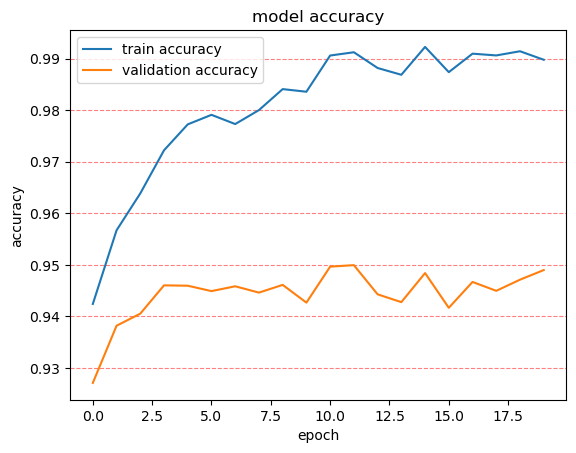

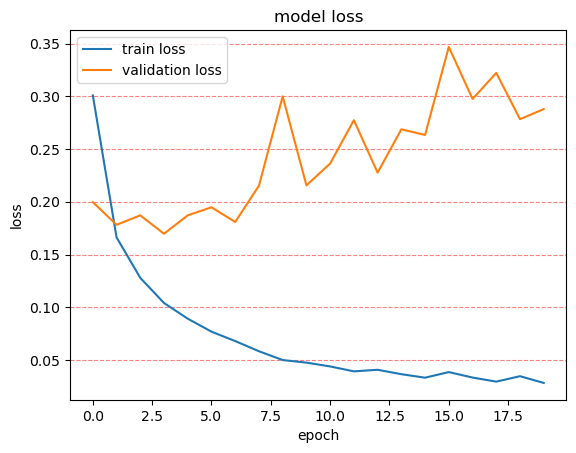

웨이퍼 탐지 모델 정확도 : 95.63%


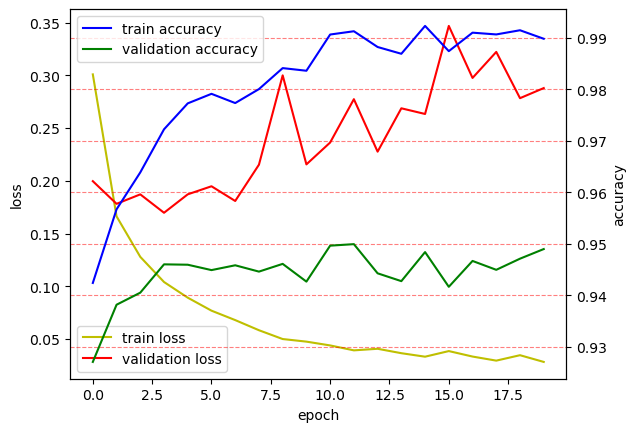

In [17]:
# 정확도 그래프
plt.plot(history['train_accuracy'], label='train accuracy')
plt.plot(history['val_accuracy'], label='validation accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
plt.show()

# 손실 그래프
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
plt.show()

# 테스트 정확도 출력
print("웨이퍼 탐지 모델 정확도 : {:5.2f}%".format(100 * test_accuracy.item()))

# 손실과 정확도를 동시에 보여주는 그래프
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history['train_loss'], 'y', label='train loss')
loss_ax.plot(history['val_loss'], 'r', label='validation loss')
acc_ax.plot(history['train_accuracy'], 'b', label='train accuracy')
acc_ax.plot(history['val_accuracy'], 'g', label='validation accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='lower left')
acc_ax.legend(loc='upper left')

plt.grid(True, axis='y', color='red', alpha=0.5, linestyle='--')
plt.show()

In [18]:
# 모델 평가 및 예측

# 모델 평가
print("")
print("-- Evaluate --")
model.eval()  # 모델을 평가 모드로 설정

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(dataloaders['test'].dataset)
test_accuracy = 100 * correct / total
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy))

# 예측
print("")
print("-- Predict --")
model.eval()  # 모델을 평가 모드로 설정

predictions = []
with torch.no_grad():
    for inputs, _ in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())

print("Predictions:", predictions)


-- Evaluate --
Test Loss: 0.2517, Test Accuracy: 95.63%

-- Predict --
Predictions: [0, 2, 5, 2, 8, 8, 4, 8, 8, 8, 0, 8, 1, 8, 8, 8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 3, 8, 8, 5, 8, 8, 8, 3, 8, 8, 7, 8, 6, 5, 8, 8, 8, 2, 8, 2, 8, 0, 8, 8, 5, 8, 3, 8, 8, 6, 8, 6, 8, 0, 3, 8, 3, 8, 2, 5, 2, 8, 6, 8, 8, 3, 8, 8, 3, 8, 7, 8, 8, 8, 3, 8, 8, 5, 8, 2, 0, 8, 8, 8, 8, 0, 8, 8, 8, 8, 4, 5, 8, 8, 8, 7, 8, 4, 2, 8, 8, 8, 4, 8, 8, 0, 8, 3, 8, 8, 8, 8, 7, 8, 4, 8, 8, 8, 3, 3, 8, 8, 8, 7, 8, 1, 8, 5, 1, 7, 6, 5, 8, 8, 8, 0, 8, 8, 6, 8, 4, 8, 8, 8, 8, 8, 8, 8, 6, 2, 4, 8, 0, 8, 8, 8, 2, 0, 0, 0, 8, 8, 8, 8, 8, 8, 2, 7, 8, 7, 8, 7, 8, 8, 8, 3, 8, 8, 1, 8, 0, 0, 8, 7, 8, 5, 8, 0, 7, 1, 2, 2, 7, 8, 8, 5, 0, 2, 8, 6, 8, 8, 4, 4, 8, 8, 8, 3, 8, 3, 8, 7, 8, 8, 8, 8, 6, 0, 6, 1, 8, 8, 7, 8, 8, 8, 6, 7, 0, 8, 6, 6, 8, 8, 8, 8, 8, 8, 8, 2, 2, 8, 8, 3, 8, 8, 8, 8, 8, 8, 2, 2, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 4, 6, 3, 1, 4, 8, 8, 8, 8, 8, 8, 8, 2, 0, 7, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 0, 8, 6, 8, 8, 4,

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# 예측값 도출 함수
def predict(model, dataloader):
    model.eval()  # 모델을 평가 모드로 설정

    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Confusion Matrix 계산 함수
def calculate_cm_metrics(y_pred, y_true):
    # Confusion Matrix 계산
    cm = confusion_matrix(y_true, y_pred)   # 매개변수 순서 : y축, x축

    # 클래스별 TP, FN, FP, TN 값 계산
    n = cm.shape[0]
    precision = np.zeros(n)
    recall = np.zeros(n)
    f1_score = np.zeros(n)
    for i in range(n):
        tp = tp = cm[i, i]
        fn = cm[i].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp

        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    accuracy = np.trace(cm) / float(np.sum(cm))
    return accuracy, precision, recall, f1_score

# 모델 평가
predictions, true_labels = predict(model, dataloaders['test'])

# 평가 메트릭 계산
acc, precision, recall, f1 = calculate_cm_metrics(predictions, true_labels)

# 계산된 평가 메트릭 출력
print('Accuracy = {:.2f}'.format(acc))
print('Precision = {:.2f}'.format(precision[0]))
print('Recall = {:.2f}'.format(recall[0]))
print('f1-score = {:.2f}'.format(f1[0]))

# scikit-learn 활용하여 평가 메트릭 계산
print('\nscikit-learn')
print('Accuracy = {:.2f}'.format(accuracy_score(true_labels, predictions)))
print('Precision = {:.2f}'.format(precision_score(true_labels, predictions, average=None)[0]))
print('Recall = {:.2f}'.format(recall_score(true_labels, predictions, average=None)[0]))
print('F1-score = {:.2f}'.format(f1_score(true_labels, predictions, average=None)[0]))

# 혼동 행렬
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    이 함수는 혼동 행렬을 표시합니다.
    정규화를 사용하려면 'normalize=True'로 설정하십시오.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




Accuracy = 0.96
Precision = 0.94
Recall = 0.93
f1-score = 0.94

scikit-learn
Accuracy = 0.96
Precision = 0.94
Recall = 0.93
F1-score = 0.94


Normalized confusion matrix


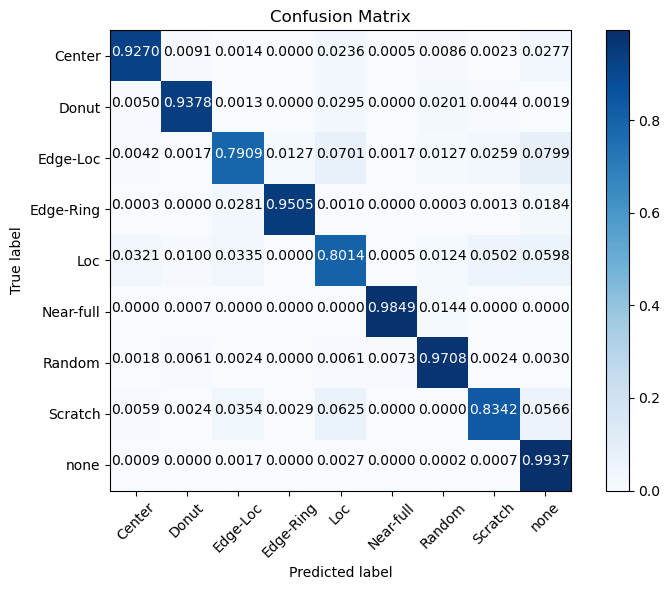

In [20]:
# 혼동 행렬 생성 및 시각

cm = confusion_matrix(true_labels, predictions)
plot_confusion_matrix(cm, classes=image_datasets['test'].classes, title='Confusion Matrix')
plt.show()